# EEG Data Statistics

`01_Data_Curation1`과 `02_Data_Curation2`에서 저장한 EEG 데이터의 분포를 전반적으로 살펴보는 노트북.

-----

## 환경 구성

In [2]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%cd ..

C:\Users\Minjae\Desktop\EEG_Project


In [3]:
# Load some packages
import os
import glob
import json
import datetime
import string

import matplotlib.pyplot as plt
import pprint
from tqdm.auto import tqdm

import numpy as np
import torch
import pyarrow.feather as feather

# custom package
from datasets.caueeg_dataset import CauEegDataset, MultiEegLabel

In [4]:
# Other settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # cleaner text

plt.style.use('default') 
# ['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 
#  'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 
#  'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 
#  'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 
#  'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']

plt.rcParams['image.interpolation'] = 'bicubic'
plt.rcParams["font.family"] = 'Helvetica' # 'NanumGothic' # for Hangul in Windows

In [5]:
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.')

1.11.0+cu113
cuda is available.


-----

## Curated Data 불러오기

In [6]:
# Data file path
curate_folder = r'local/dataset/02_Curated_Data_220419'
output_folder = r'local/output/imgs'

os.makedirs(output_folder, exist_ok=True)

In [7]:
with open(os.path.join(curate_folder, 'annotation_debug.json'), 'r') as json_file:
    annotation = json.load(json_file)

pprint.pprint({k: (v if k != 'data' else v[:5]) for (k, v) in annotation.items()}, width=250)

{'data': [{'age': 78, 'birth': '1940-06-02', 'dx1': 'mci_rf', 'edfname': '00001809_261018', 'record': '2018-10-26T15:46:26', 'serial': '00001', 'symptom': ['mci', 'mci_amnestic', 'mci_amnestic_rf']},
          {'age': 56, 'birth': '1960-12-04', 'dx1': 'smi', 'edfname': '00029426_020817', 'record': '2017-08-02T16:14:56', 'serial': '00002', 'symptom': ['normal', 'smi']},
          {'age': 93, 'birth': '1924-10-19', 'dx1': 'vascular mci', 'edfname': '00047327_090718', 'record': '2018-07-09T15:29:10', 'serial': '00003', 'symptom': ['mci', 'mci_vascular']},
          {'age': 78, 'birth': '1941-03-16', 'dx1': 'load', 'edfname': '00048377_070819', 'record': '2019-08-07T13:55:25', 'serial': '00004', 'symptom': ['dementia', 'ad', 'load']},
          {'age': 75, 'birth': '1941-03-16', 'dx1': 'mci (ef) multi-domain', 'edfname': '00048377_070916', 'record': '2016-09-07T10:36:01', 'serial': '00005', 'symptom': ['mci', 'mci_amnestic', 'mci_amnestic_ef', 'mci_multi_domain']}],
 'dataset_name': 'CAUEE

-----

## 샘플 신호열 시각화

In [8]:
print(len(annotation["data"]))
print()

pprint.pprint(annotation["data"][0])
print()

fname = os.path.join(curate_folder, 'signal/feather', annotation["data"][0]['serial'] + '.feather')
signal = feather.read_feather(fname)
print(signal.values.T.shape)

for idx in signal.columns:
    print(idx.split('-')[0])
    
signal.head()

1379

{'age': 78,
 'birth': '1940-06-02',
 'dx1': 'mci_rf',
 'edfname': '00001809_261018',
 'record': '2018-10-26T15:46:26',
 'serial': '00001',
 'symptom': ['mci', 'mci_amnestic', 'mci_amnestic_rf']}

(21, 145000)
Fp1
F3
C3
P3
O1
Fp2
F4
C4
P4
O2
F7
T3
T5
F8
T4
T6
FZ
CZ
PZ
EKG
Photic


,Fp1-AVG,F3-AVG,C3-AVG,P3-AVG,O1-AVG,Fp2-AVG,F4-AVG,C4-AVG,P4-AVG,O2-AVG,...,T3-AVG,T5-AVG,F8-AVG,T4-AVG,T6-AVG,FZ-AVG,CZ-AVG,PZ-AVG,EKG,Photic
0,0,29,-3,0,-1,-4,-12,-10,-8,-4,...,-2,3,18,0,-2,16,-6,-4,112,-1
1,-11,33,-6,2,-2,2,-9,-7,-5,-3,...,-4,2,28,4,-1,-3,-7,-2,67,-1
2,-13,34,-3,3,-3,4,-9,-7,-4,-4,...,-5,-2,29,4,-2,-5,-4,1,76,-1
3,-11,36,-1,2,-3,2,-8,-8,-4,-4,...,-6,-5,28,2,-3,-2,-1,2,87,1
4,-7,38,-3,-2,-6,3,-4,-4,-5,-4,...,-8,-7,28,2,-5,4,0,0,74,2


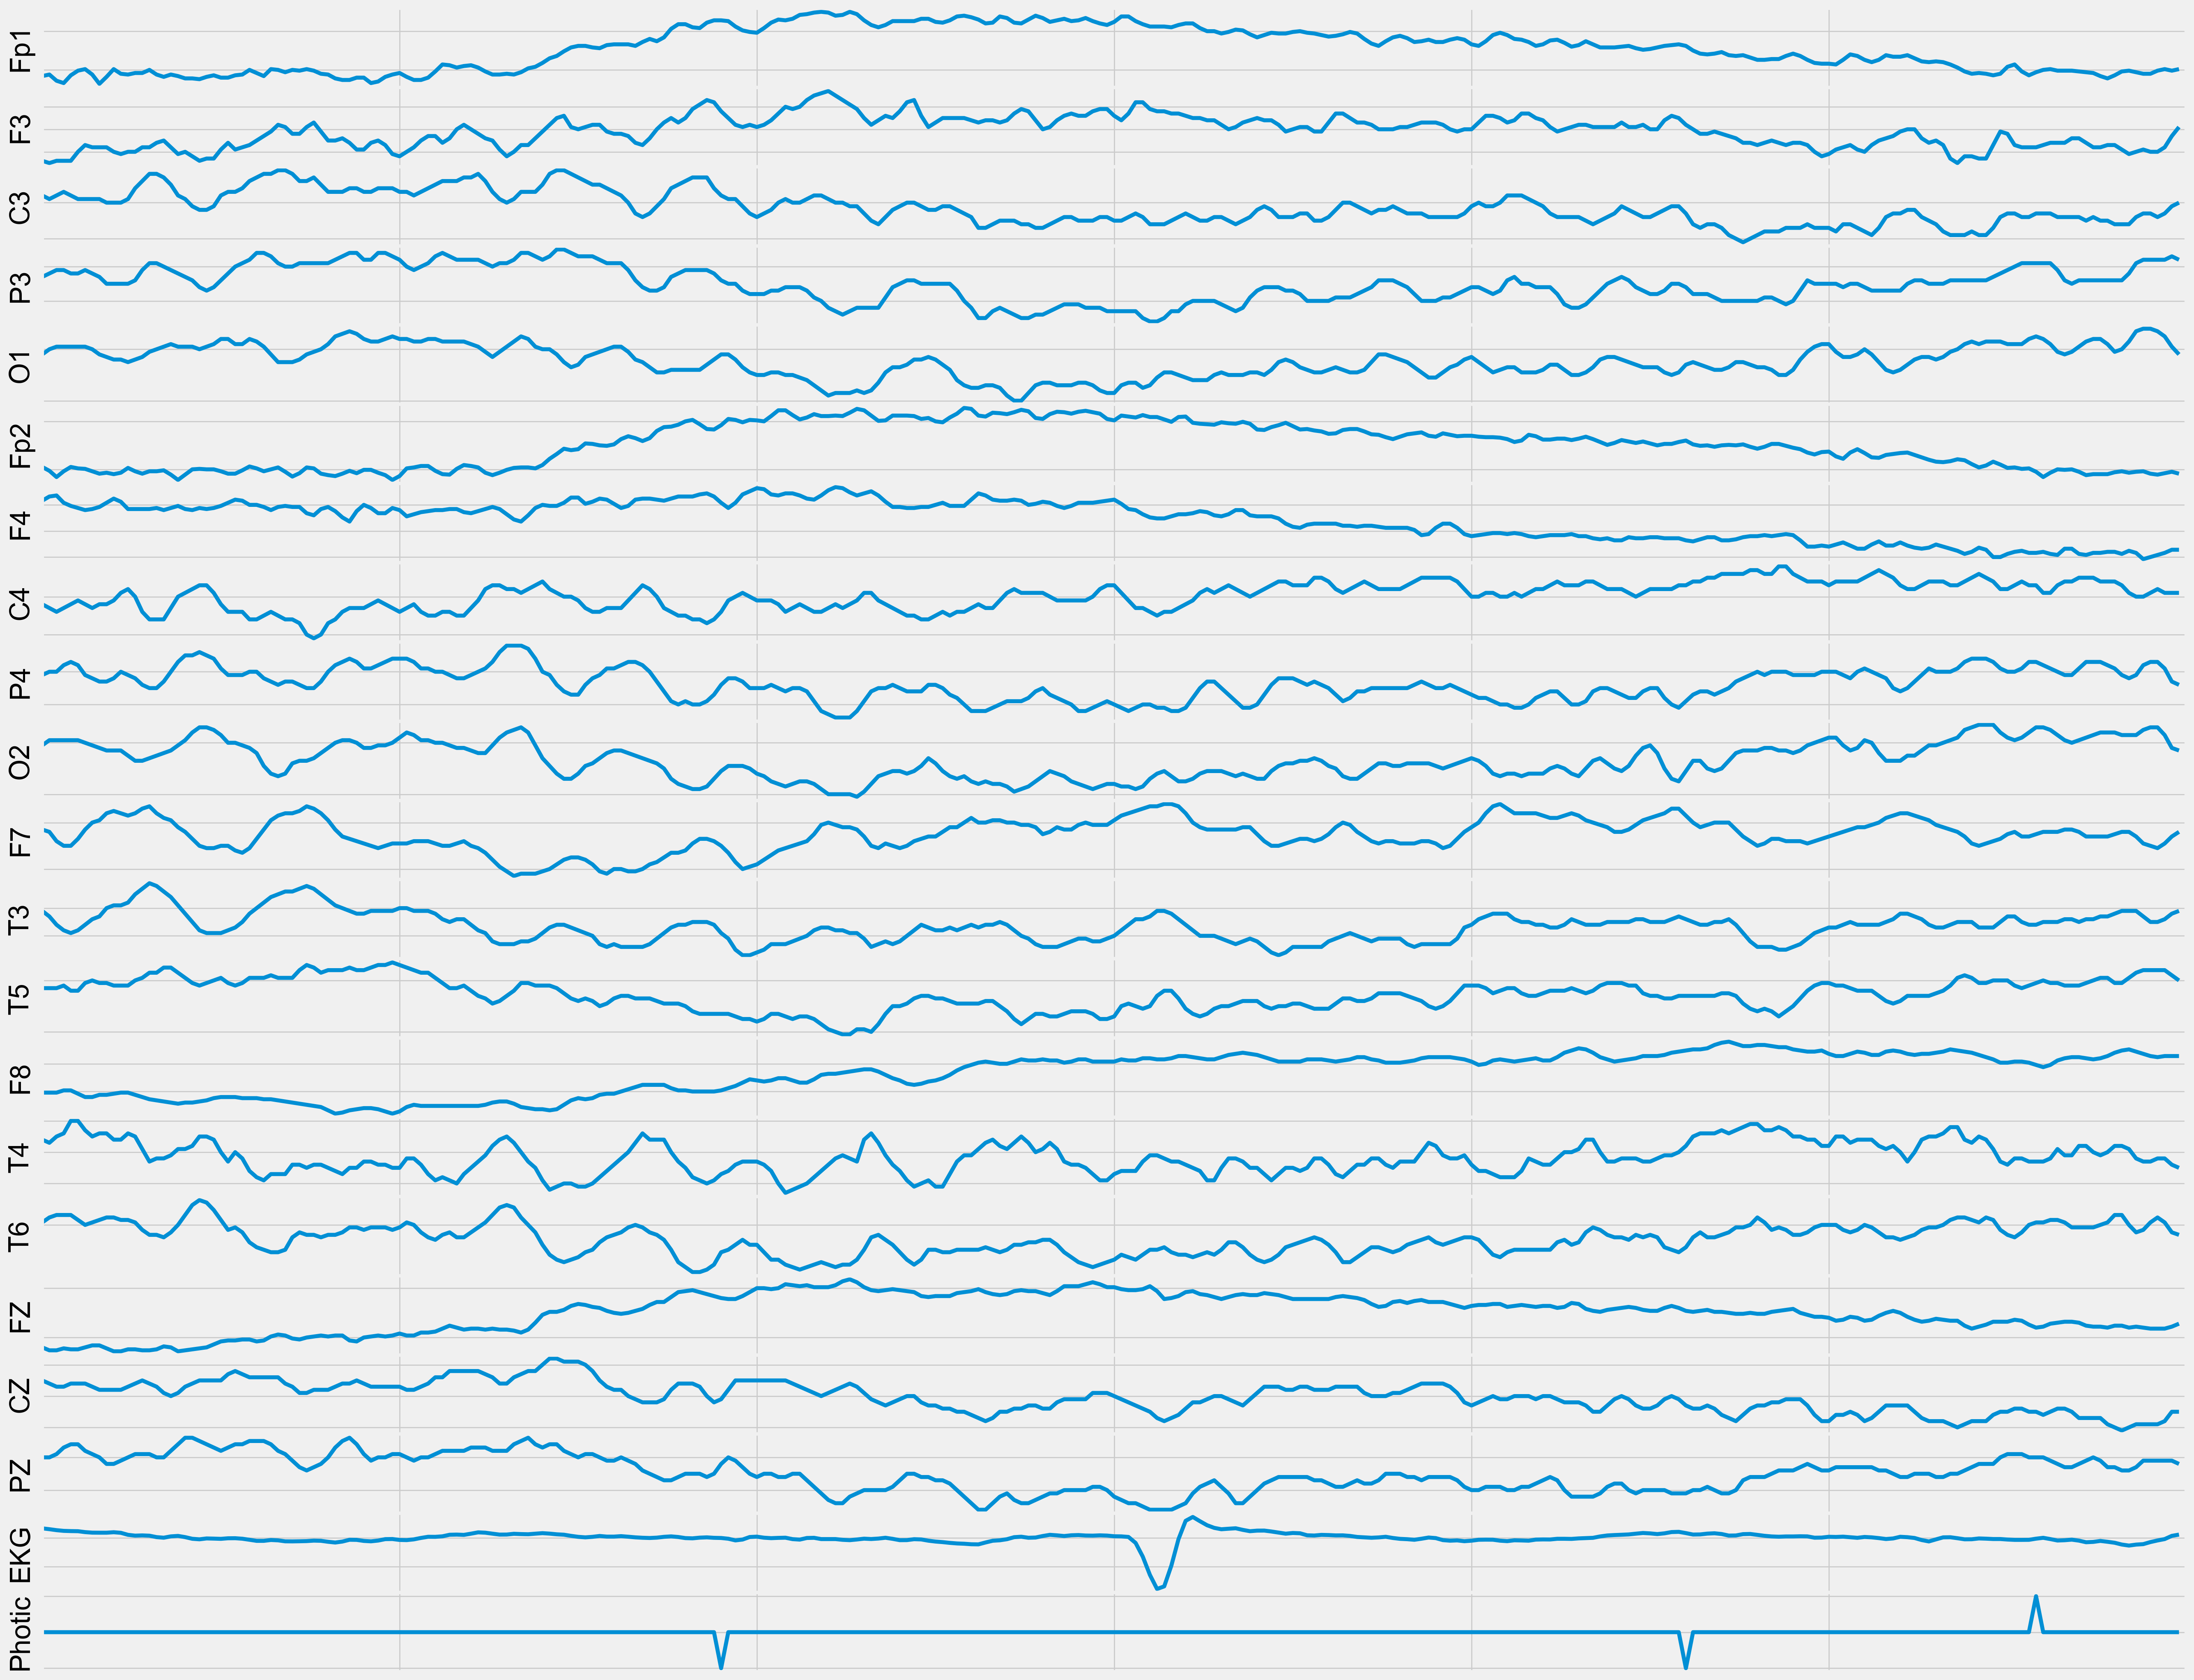

In [9]:
plt.style.use('default') 
plt.style.use('fivethirtyeight') # default, ggplot, fivethirtyeight, bmh, dark_background, classic
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams["savefig.dpi"] = 1200

start = 51000
end = 51300

fig = plt.figure(num=1, clear=True, figsize=(30.0, 25.0))
fig.subplots_adjust(hspace=0)

for i, channel in enumerate(signal.columns):
    ax = fig.add_subplot(len(signal.columns), 1, i + 1)
    ax.plot(signal[channel][start:end], lw=3.5)
    ax.set_xlim(start, end)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_ylabel(channel.split('-')[0])

# ax.set_title('Diagnoses in DB')
# ax.set_xlabel('Diagnosis')
# ax.set_ylabel('The number of recordings')

fig.savefig(os.path.join(output_folder, 'signal_example.pdf'), transparent=True)
plt.show()
fig.clear()
plt.close(fig)

-----

## 총 환자수

In [10]:
a = set()
for m in annotation["data"]:
    a.add(m['edfname'].split('_')[0])

print(len(a))

1155


-----

## 기간

In [11]:
a = []
for m in annotation["data"]:
    a.append(m['record'])

print(len(a))
pprint.pprint(sorted(a)[0])
pprint.pprint(sorted(a)[-1])

1379
'2012-08-24T14:19:42'
'2020-03-12T09:14:47'


-----

## 데이터 통계

- Signal dynamic range
- Signal mean and variance
- Signal length
- Age
- Diagnosis

In [12]:
hist_min = []
hist_max = []
hist_mean = []
hist_var = []

hist_length = []
hist_age = []
dict_diagnosis = {}

for (k, m) in enumerate(tqdm(annotation["data"])):
    fname = os.path.join(curate_folder, 'signal/feather', m['serial'] + '.feather')
    signal = feather.read_feather(fname).values.T
    
    hist_min.append(np.amin(signal, axis=1))
    hist_max.append(np.amax(signal, axis=1))
    hist_mean.append(np.mean(signal, axis=1))
    hist_var.append(np.var(signal, axis=1))
    
    hist_length.append(signal.shape[1])
    hist_age.append(m['age'])
    
    # d = MultiLabel(**{k: True for k in m['symptom']})
    for l in m['symptom']:
        dict_diagnosis[l] = dict_diagnosis.get(l, 0) + 1
    
hist_min = np.array(hist_min).T
hist_max = np.array(hist_max).T
hist_mean = np.array(hist_mean).T
hist_var = np.array(hist_var).T

hist_length = np.array(hist_length)
hist_age = np.array(hist_age)

print('Done.')

  0%|          | 0/1379 [00:00<?, ?it/s]

Done.


#### Signal min, max, mean, and var

In [13]:
plt.style.use('default') 

ind = np.argsort(np.sum(hist_max - hist_min, axis=0))

for i in tqdm(range(len(annotation["signal_header"]))):
    fig = plt.figure(num=1, clear=True, 
                 figsize=(60.0, 40.0), constrained_layout=True)

    ax = fig.add_subplot(1, 1, 1)
    ax.plot(hist_min[i, ind], 'b--', linewidth=1.2, label='min')
    ax.plot(hist_max[i, ind], 'c--', linewidth=1.2, label='max')
    ax.plot(hist_mean[i, ind], 'r-', linewidth=1.2, label='mean')
    ax.fill_between(np.arange(hist_mean[i].shape[0]),
                    hist_mean[i, ind] - hist_var[i, ind] / 20, 
                    hist_mean[i, ind] + hist_var[i, ind] / 20, 
                    color='m', alpha=0.4, label='var')

    ax.set_title(annotation["signal_header"][i], fontsize=70)
    plt.legend(loc='upper center', shadow=True, fontsize=70).get_frame().set_facecolor('white')

    fig.savefig(os.path.join(output_folder, f'signal_statistics_c{i + 1:02}.png'))

    fig.clear()
    plt.close(fig)
    
print('Done.')

  0%|          | 0/21 [00:00<?, ?it/s]

Done.


#### Signal length

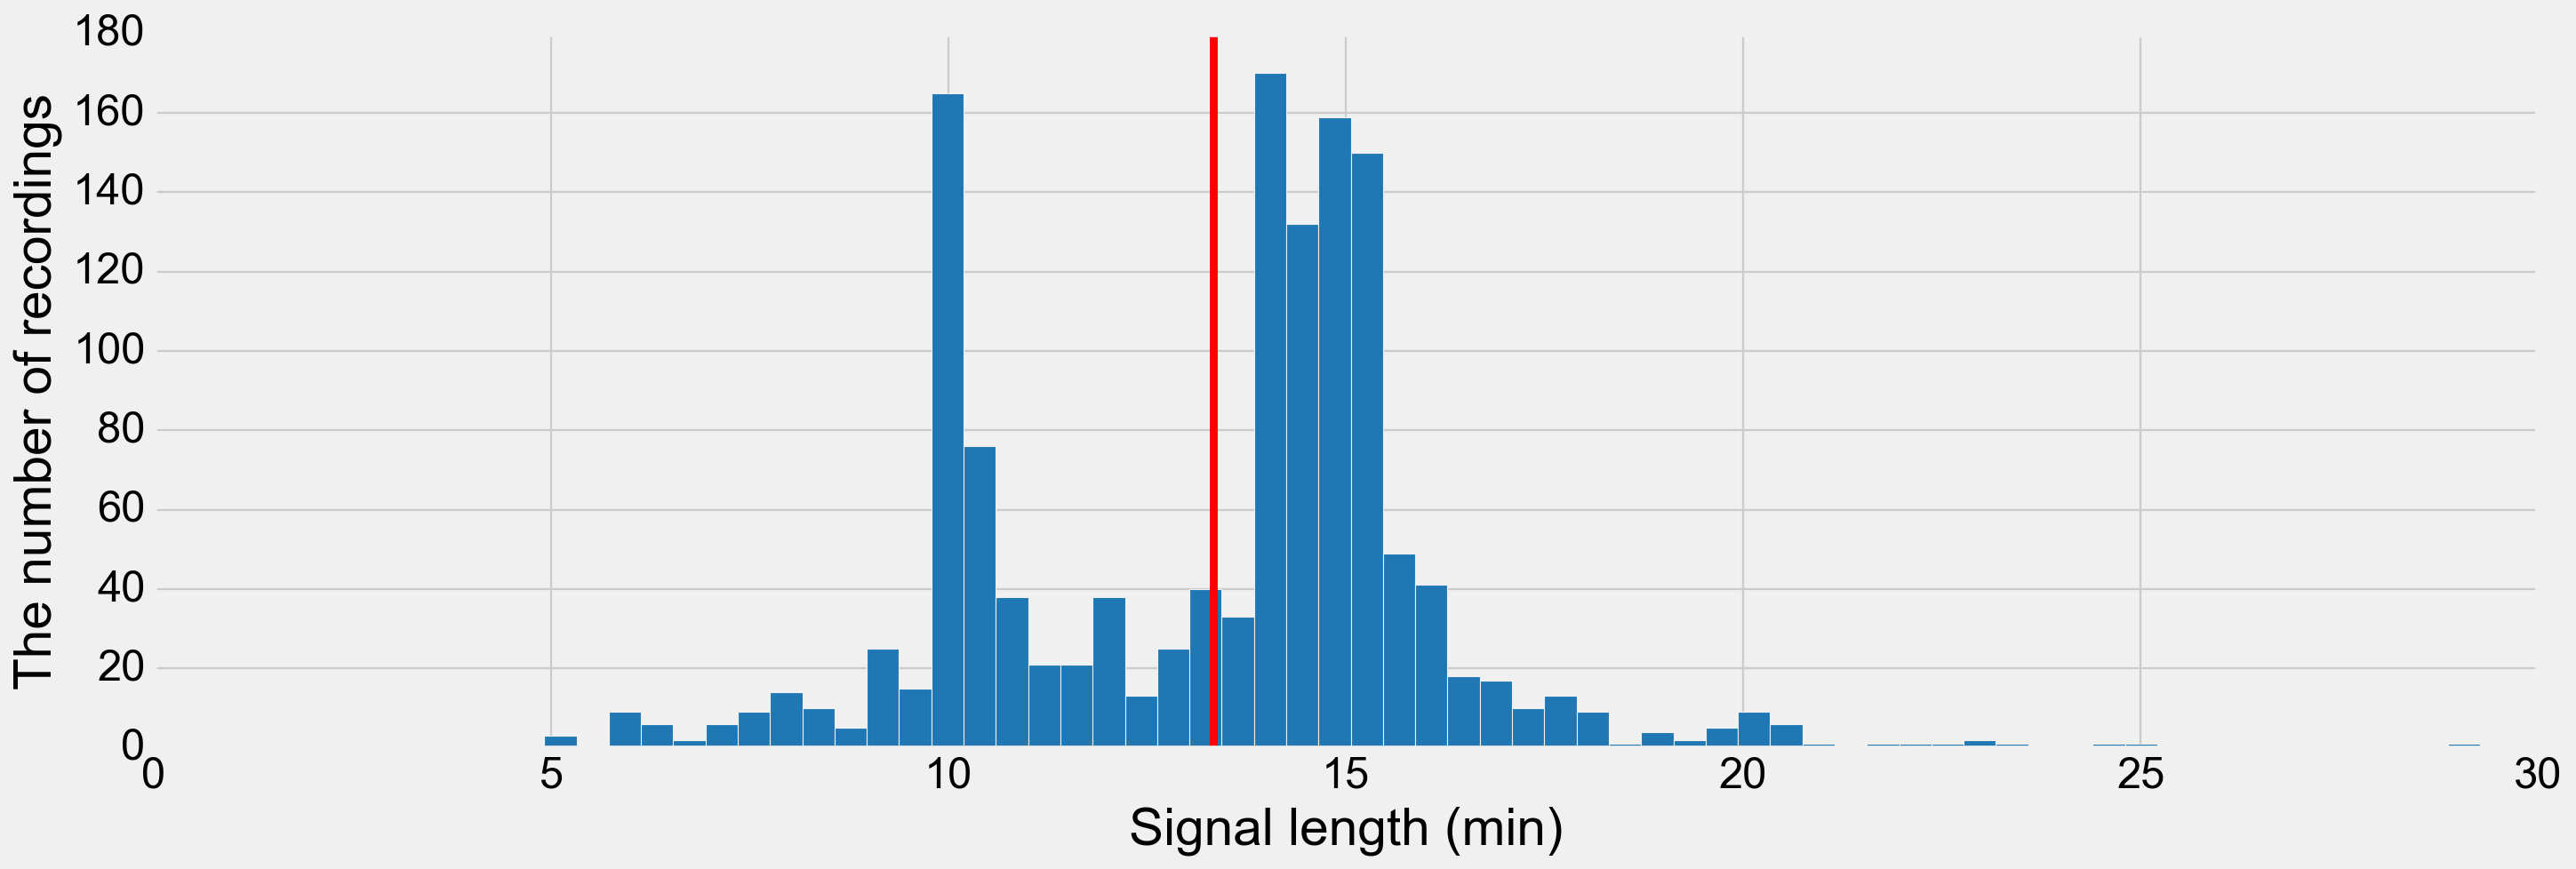

4.916666666666667
29.266666666666666
13.33942470389171
2.8274117974917883


In [14]:
plt.style.use('classic')
plt.style.use('fivethirtyeight') # default, ggplot, fivethirtyeight, classic
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams["savefig.dpi"] = 1200

fig = plt.figure(num=1, clear=True, 
                 figsize=(18.0, 6.0), constrained_layout=True)

ax = fig.add_subplot(1, 1, 1)
# ax.hist(hist_length / (60 * 200), histtype='stepfilled', color='k', bins=50)
ax.hist(hist_length / (60 * 200), bins=60, color='tab:blue')
ax.vlines(np.mean(hist_length) / (60 * 200), 0, 1, transform=ax.get_xaxis_transform(), colors='r')
# ax.set_title('Signal Length Distribution')
ax.set_xlabel('Signal length (min)')
ax.set_ylabel('The number of recordings')

fig.savefig(os.path.join(output_folder, 'signal_length_distribution.pdf'), transparent=True)

plt.show()
fig.clear()
plt.close(fig)

print(min(hist_length) / 200 / 60)
print(max(hist_length) / 200 / 60)
print(np.mean(hist_length) / 200 / 60)
print(np.std(hist_length) / 200 / 60)

#### Age

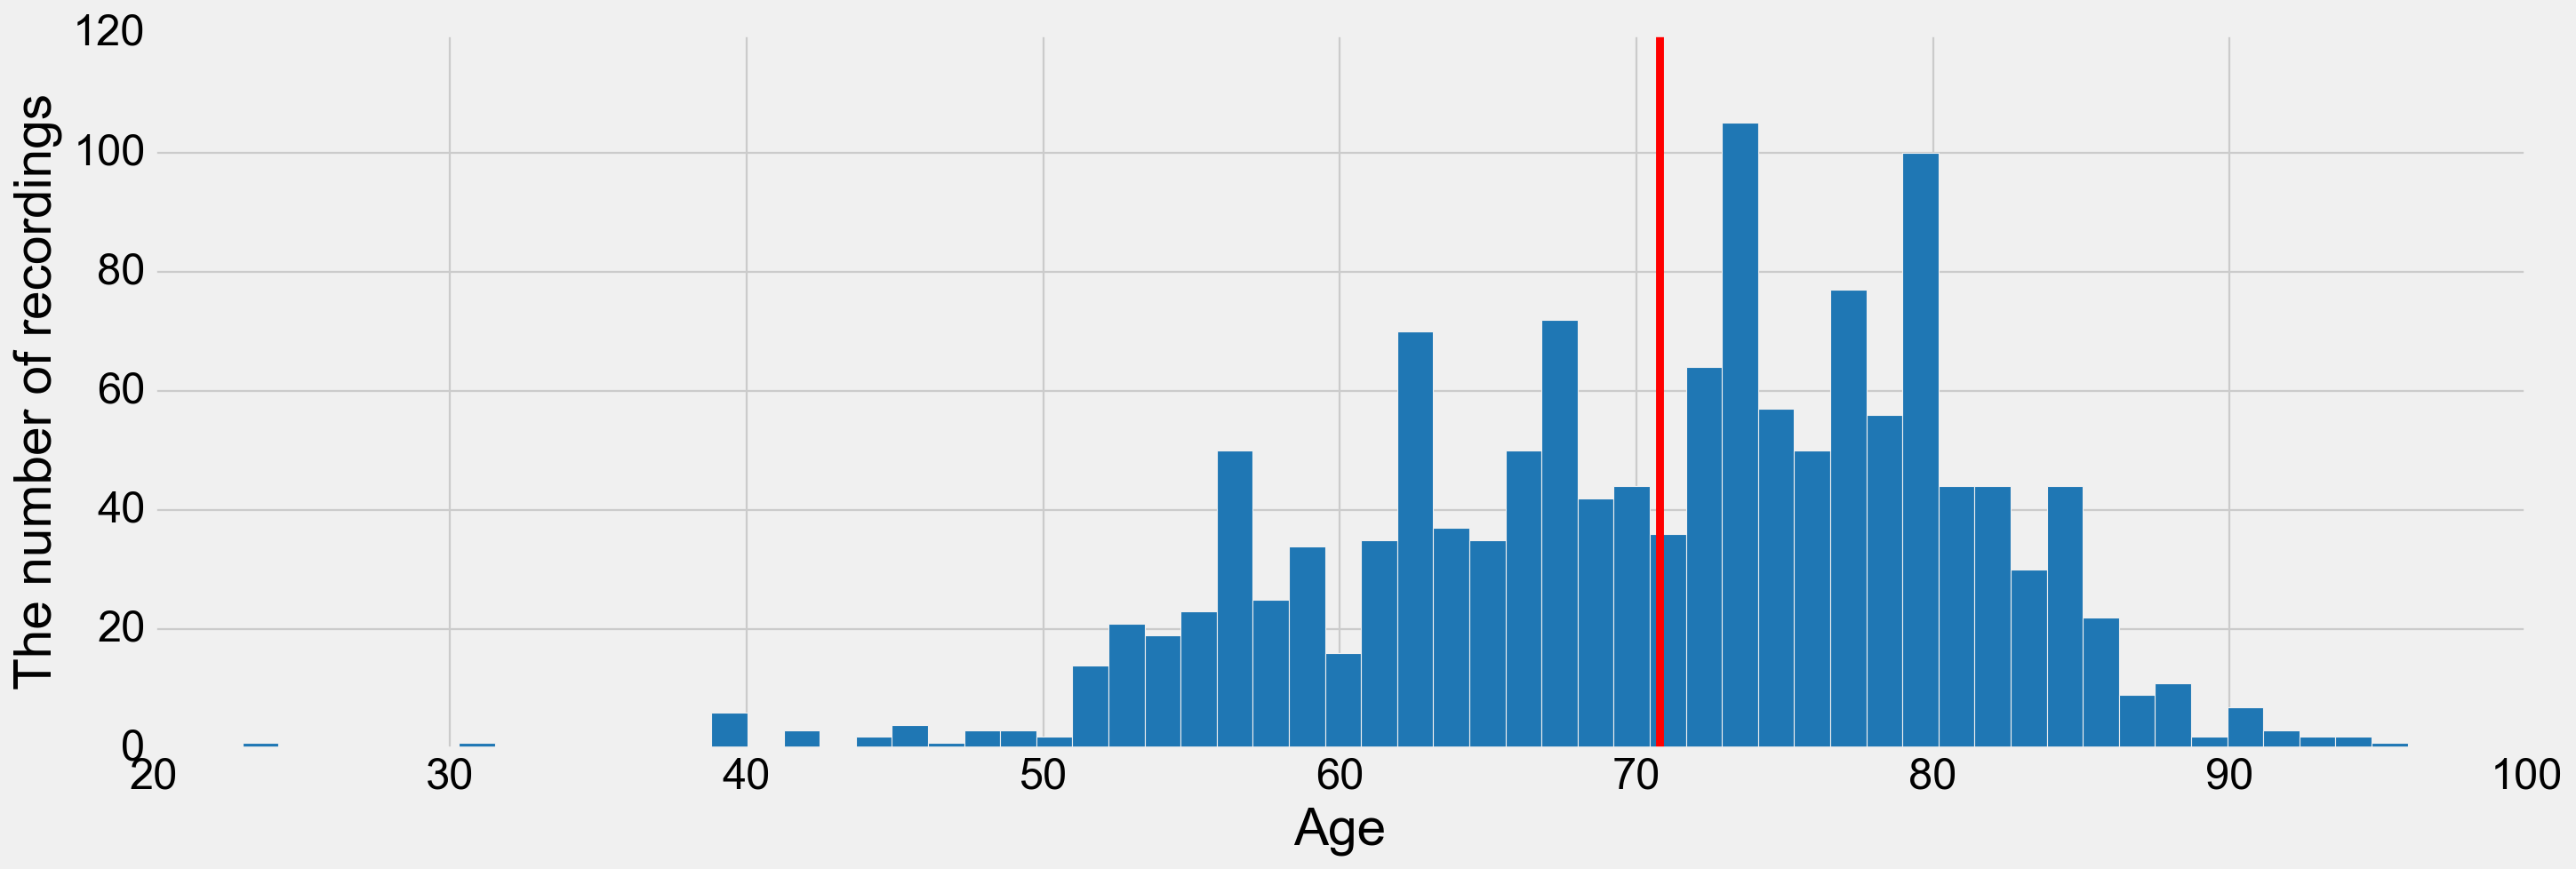

23
96
70.76649746192894
9.903186622556174


In [55]:
plt.style.use('classic')
plt.style.use('fivethirtyeight') # default, ggplot, fivethirtyeight, classic
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams["savefig.dpi"] = 1200

fig = plt.figure(num=1, clear=True, 
                 figsize=(18.0, 6.0), constrained_layout=True)

ax = fig.add_subplot(1, 1, 1)
ax.hist(hist_age, bins=60, color='tab:blue')
ax.vlines(np.mean(hist_age), 0, 1, transform=ax.get_xaxis_transform(), colors='r')
# ax.set_title('Age distribution')
ax.set_xlabel('Age')
ax.set_ylabel('The number of recordings')

fig.savefig(os.path.join(output_folder, 'age_distribution.pdf'), transparent=True)

plt.show()
fig.clear()
plt.close(fig)

print(min(hist_age))
print(max(hist_age))
print(np.mean(hist_age))
print(np.std(hist_age))

#### Diagnosis

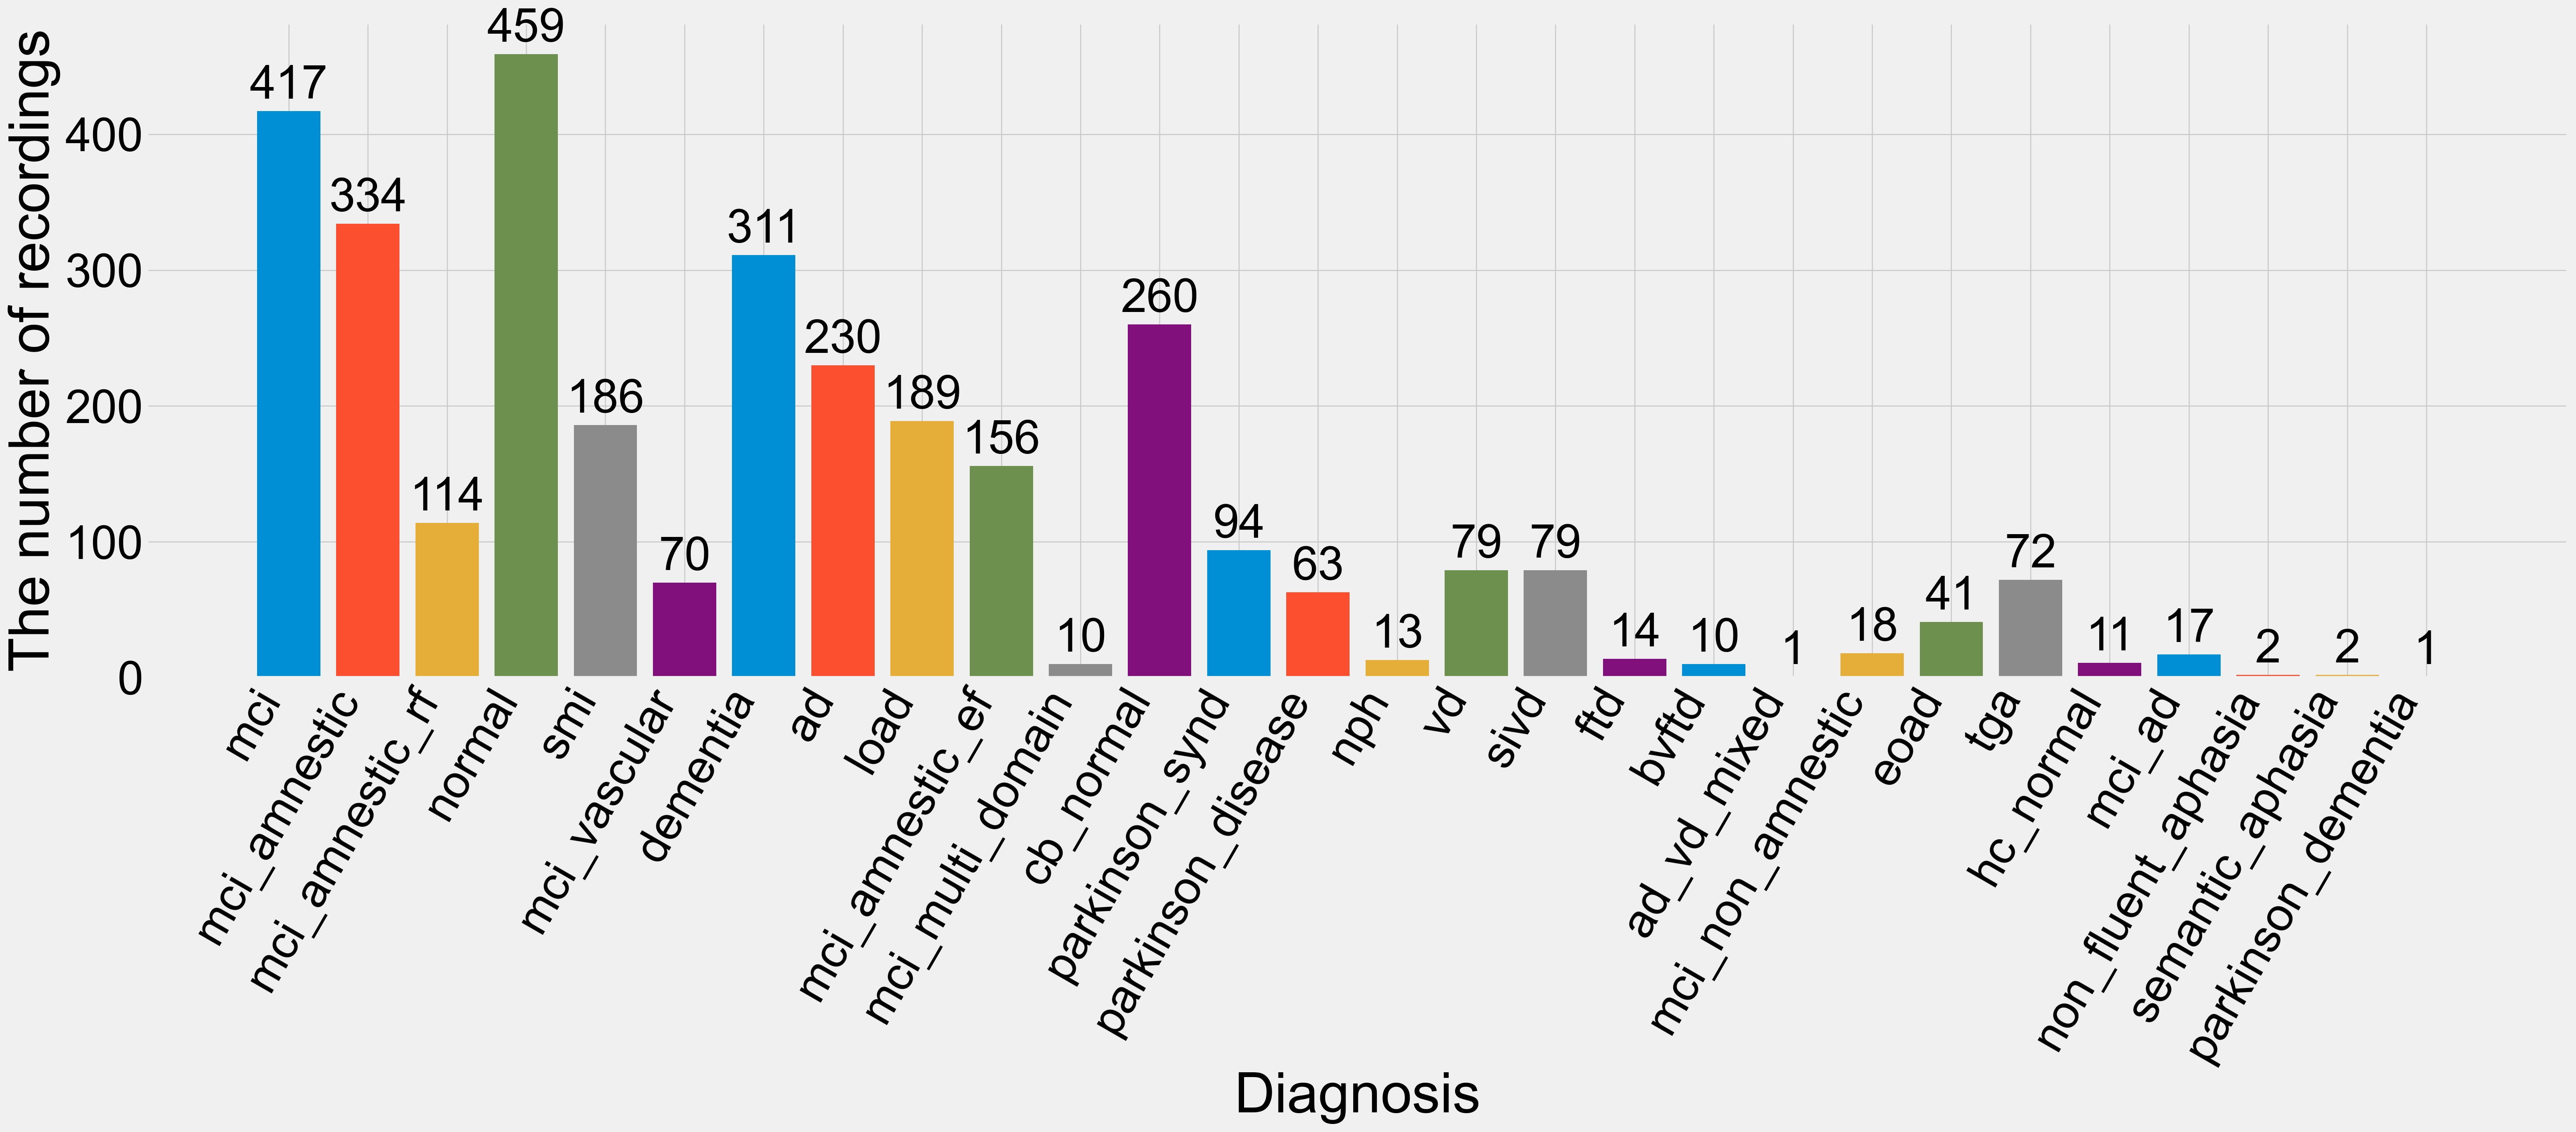

In [15]:
plt.style.use('default') 
plt.style.use('fivethirtyeight') # default, ggplot, fivethirtyeight, classic
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams["savefig.dpi"] = 1200

from cycler import cycler
cc = cycler(color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
                   'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])

fig = plt.figure(num=1, clear=True,
                 figsize=(32.0, 14.0), constrained_layout=True)

ax = fig.add_subplot(1, 1, 1)
non_zero_labels = []
for d in dict_diagnosis.keys():
    if dict_diagnosis.get(d, 0) > 0:
        non_zero_labels.append(d)

for d, c in zip(non_zero_labels, cc()):
    # rect = ax.bar(d, dict_diagnosis.get(d, 0), **c, alpha=0.8)
    rect = ax.bar(d, dict_diagnosis.get(d, 0))
    ax.bar_label(rect, padding=3)
    
# rect = ax.bar(*zip(*dict_diagnosis.items()))
# ax.bar_label(rect, padding=3)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right")
# ax.set_title('Diagnoses in DB')
ax.set_xlabel('Diagnosis')
ax.set_ylabel('The number of recordings')

fig.savefig(os.path.join(output_folder, 'diagnosis_distribution.pdf'), transparent=True)

plt.show()
fig.clear()
plt.close(fig)

-----

## 전처리 방법 모색하기

#### Signal min, max, mean, and var after per-signal mean-std normalization

In [ ]:
hist_min_norm = []
hist_max_norm = []
hist_mean_norm = []
hist_var_norm = []

for (k, m) in enumerate(tqdm(annotation["data"])):
    fname = os.path.join(curate_folder, 'signal/feather', m['serial'] + '.feather')
    signal = feather.read_feather(fname).values.T    
    
    m = np.mean(signal, axis=1, keepdims=True)
    std = np.std(signal, axis=1, keepdims=True)
    signal = (signal - m) / (std + 1e-8)
    
    hist_min_norm.append(np.amin(signal, axis=1))
    hist_max_norm.append(np.amax(signal, axis=1))
    hist_mean_norm.append(np.mean(signal, axis=1))
    hist_var_norm.append(np.var(signal, axis=1))
    
hist_min_norm = np.array(hist_min_norm).T
hist_max_norm = np.array(hist_max_norm).T
hist_mean_norm = np.array(hist_mean_norm).T
hist_var_norm = np.array(hist_var_norm).T

print('Done.')

In [ ]:
plt.style.use('default') 

# ind = np.argsort(np.sum(hist_max_norm - hist_min_norm, axis=0))
ind = np.argsort(np.sum(hist_max - hist_min, axis=0))

for i in tqdm(range(len(annotation["signal_header"]))):
    fig = plt.figure(num=1, clear=True, 
                 figsize=(60.0, 40.0), constrained_layout=True)

    ax = fig.add_subplot(1, 1, 1)
    ax.plot(hist_min_norm[i, ind], 'b--', linewidth=1.2, label='min')
    ax.plot(hist_max_norm[i, ind], 'c--', linewidth=1.2, label='max')
    ax.plot(hist_mean_norm[i, ind], 'r-', linewidth=1.2, label='mean')
    ax.fill_between(np.arange(hist_mean_norm[i].shape[0]),
                    hist_mean_norm[i, ind] - hist_var_norm[i, ind], 
                    hist_mean_norm[i, ind] + hist_var_norm[i, ind], 
                    color='m', alpha=0.4, label='var')

    ax.set_title(annotation["signal_header"][i] + ' after per-signal mean-std normalization', fontsize=70)
    plt.legend(loc='upper center', shadow=True, fontsize=70).get_frame().set_facecolor('white')

    fig.savefig(os.path.join(output_folder, f'signal_statistics_c{i + 1:02}_norm.png'))

    fig.clear()
    plt.close(fig)
    
print('Done.')

-----

## 이벤트 종류 및 발생 빈도수

In [ ]:
event_dict = dict()

for m in annotation["data"]:
    fname = os.path.join(curate_folder, 'event', m['serial'] + '.json')
    with open(fname, 'r') as json_file:
        event = json.load(json_file)
    
    for (t, e) in event:
        event_dict[e] = event_dict.get(e, 0) + 1
        
pprint.pprint(sorted(event_dict.items(), key=lambda x: x[1], reverse=True))

-----

## 이벤트 전후의 신호열 시각화

In [ ]:
for m in tqdm(annotation["data"][:10]):
    
    path = os.path.join(output_folder, m["serial"])
    os.makedirs(path, exist_ok=True)
    
    fname = os.path.join(curate_folder, 'signal/feather', m['serial'] + '.feather')
    signal = feather.read_feather(fname).values.T
    
    fname = os.path.join(curate_folder, 'event', m['serial'] + '.json')
    with open(fname, 'r') as json_file:
        event = json.load(json_file)
    
    for i, (t, e) in enumerate(event):
        fig = plt.figure(num=1, clear=True, 
                         figsize=(14.0, 5), constrained_layout=True)
        ax = fig.add_subplot(1, 1, 1)

        width = 400
        st, et = t - width, t + width
        if st < 0: 
            st, et = 0, width*2
        elif signal.shape[1] < et: 
            st, et = signal.shape[1] - width*2, signal.shape[1]

        for (k, h) in enumerate(annotation["signal_header"]):
            ax.plot(np.arange(st, et) / 200, signal[k, st:et], label=h)
            ax.vlines([t / 200], 0, 1, transform=ax.get_xaxis_transform(), colors='r')

        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_title(e)

        fname = f'{str(i+1):>03}_{e}.png'
        safechars = string.ascii_lowercase + string.ascii_uppercase + string.digits + '.-_'
        fname = ''.join([c for c in fname if c in safechars])

        fig.savefig(os.path.join(path, fname))
        fig.clear()
        plt.close(fig)
        
print('Done.')

-----

## Eye open 과 Eye closed 이벤트 사이의 시간 간격 시각화

In [ ]:
for m in annotation["data"]:
    started = True
    opened = False
    t = 0
    intervals = []
    warns = []
    
    fname = os.path.join(curate_folder, 'event', m['serial'] + '.json')
    with open(fname, 'r') as json_file:
        event = json.load(json_file)
    
    for e in event:
        if e[1].lower() == 'eyes open':
            if started:
                started = False
                t = e[0]
                opened = True
            elif opened:
                t = e[0]
                warns.append(f'open-open: {e}')
            else:
                t = e[0]
                opened = True
        elif e[1].lower() == 'eyes closed':
            if started:
                started = False
                opened = False
            elif opened:
                opened = False
                intervals.append(e[0] - t)
            else:
                warns.append(f'close-close: {e}')

    print(m['serial'], warns, intervals)

In [ ]:
for m in annotation["data"]:
    started = True
    opened = False
    t = 0
    intervals = []
    warns = []
    
    fname = os.path.join(curate_folder, 'event', m['serial'] + '.json')
    with open(fname, 'r') as json_file:
        event = json.load(json_file)
    
    for e in event:
        if e[1].lower() == 'eyes open':
            if started:
                started = False
                opened = True
            elif opened:
                warns.append(f'open-open: {e}')
            else:
                intervals.append(e[0] - t)
                opened = True
        elif e[1].lower() == 'eyes closed':
            if started:
                started = False
                opened = False
                t = e[0]
            elif opened:
                opened = False
                t = e[0]
            else:
                t = e[0]
                warns.append(f'close-close: {e}')

    print(m['serial'], warns, intervals)

-----

## Spectrogram 생김새 확인

#### PyTorch stft function

In [ ]:
# plt.style.use('ggplot')
# plt.rcParams['figure.figsize'] = (8, 4) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'jet' # 'nipy_spectral'

for m in tqdm(annotation["data"][:2]):
    fname = os.path.join(curate_folder, 'signal/feather', m['serial'] + '.feather')
    signal = feather.read_feather(fname).values.T
    signal = torch.from_numpy(signal).to(dtype=torch.float32)
    signal_f = torch.stft(signal, n_fft=200, center=True, return_complex=True)
    
    # Signiture: (input, n_fft, hop_length=None, 
    #             win_length=None, window=None, center=True, 
    #             pad_mode='reflect', normalized=False, 
    #             onesided=None, return_complex=None)    
    
    print(signal.shape, signal_f.shape, signal.shape[1] / (200 / 4) + 1)
    
    signal_f = torch.view_as_real(signal_f).numpy()[..., 0]
    channels = signal_f.shape[0]
    
    fig = plt.figure(num=1, clear=True, figsize=(30.0, 30.0), 
                     constrained_layout=True)
    
    for k in range(channels):
        ax = fig.add_subplot(channels // 7, 7, k + 1)
        ax.imshow(signal_f[k], interpolation='nearest')
        ax.set_title(annotation["signal_header"][k], fontsize=14)
        ax.invert_yaxis()
    fig.suptitle('Spectrograms: ({}, {})'.format(m['serial'], m['dx1']), fontsize=23)
    fig.supxlabel('Time (s)', fontsize=20)
    fig.supylabel('Frequency (Hz)', fontsize=20)
    plt.savefig(os.path.join(output_folder, f'{m["serial"]}.png'))
    
    fig.clear()
    plt.close(fig)
    
print('Done.')

#### MatPlotLib specgram function

In [ ]:
for m in tqdm(annotation["data"][:2]):
    fname = os.path.join(curate_folder, 'signal/feather', m['serial'] + '.feather')
    signal = feather.read_feather(fname).values.T
    
    fig, ax = plt.subplots(3, 7, figsize=(30.0, 10.0),
                           constrained_layout=True)
    for k in range(21):
        Pxx, freqs, bins, im = ax[k // 7, k % 7].specgram(signal[k, :12000], 200, 200)
        ax[k // 7, k % 7].set_title(annotation["signal_header"][k], fontsize=14)
        ax[k // 7, k % 7].invert_yaxis()
        # ax[k // 7, k % 7].set_xlabel('Time (s)')
        # ax[k // 7, k % 7].set_ylabel('')
        
    fig.suptitle('Spectrograms: ({}, {})'.format(m['serial'], m['dx1']), fontsize=23)
    fig.supxlabel('Time (s)', fontsize=20)
    fig.supylabel('Frequency (Hz)', fontsize=20)
    plt.savefig(os.path.join(output_folder, f'{m["serial"]}.png'))
    plt.close('all')
    
print('Done.')

#### Real vs Complex

In [ ]:
for m in tqdm(annotation["data"][:2]):
    fname = os.path.join(curate_folder, 'signal/feather', m['serial'] + '.feather')
    signal = feather.read_feather(fname).values.T
    signal = torch.from_numpy(signal).to(dtype=torch.float32)
    signal_f = torch.stft(signal, n_fft=200, center=True, return_complex=True)
    
    # Signiture: (input, n_fft, hop_length=None, 
    #             win_length=None, window=None, center=True, 
    #             pad_mode='reflect', normalized=False, 
    #             onesided=None, return_complex=None)    
    
    print(signal.shape, signal_f.shape, signal.shape[1] / (200 / 4) + 1)
    
    signal_f = torch.view_as_real(signal_f)
    signal_f_real = signal_f[..., 0]
    signal_f_complex = torch.flip(-signal_f[..., 1], dims=[0])
    
print('Done.')